In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import NMF
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.externals import joblib

import string

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
companies = ['nikesupport','xboxsupport','upshelp','comcastcares','amazonhelp','jetblue','americanair',
             'tacobellteam','mcdonalds','kimpton','ihgservice','spotifycares','hiltonhelp','applesupport',
             'microsofthelps','googleplaymusic','scsupport','pandorasupport','hoteltonightcx','dunkindonuts',
             'jackbox','chipotletweets','askpanera','carlsjr','att','tmobilehelp','sprintcare','verizonsupport',
             'boostcare','uscellularcares','alaskaair','virginamerica','virginatlantic','delta','british_airways',
             'southwestair','awssupport','twittersupport','askplaystation','neweggservice','dropboxsupport',
             'hpsupport','atviassist','azuresupport','nortonsupport','dellcares','hulu_support','askrobinhood',
             'officesupport','arbyscares','pearsonsupport','yahoocare','idea_cares','airtel_care','coxhelp',
             'kfc_uki_help','asurioncares','adobecare','glocare','sizehelpteam','airasiasupport','safaricom_care',
             'oppocarein','bofa_help','chasesupport','askciti','ask_wellsfargo','keybank_help','moo','centurylinkhelp',
             'mediatemplehelp','godaddyhelp','postmates_help','doordash_help','airbnbhelp','uber_support','asklyft',
             'askseagate','ask_spectrum','askpaypal','asksalesforce','askvirginmoney','askdsc','askpapajohns','askrbc',
             'askebay','asktigogh','vmucare','askamex','ask_progressive','mtnc_care','askvisa','tesco','sainsburys',
             'walmart','asktarget','morrisons','aldiuk','argoshelpers','greggsofficial','marksandspencer','virgintrains',
             'nationalrailenq','sw_help','londonmidland','gwrhelp','tfl','o2']

## Functions

### Display Topics

In [3]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [5]:
def display_topics2(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

### Get Topics

In [6]:
def get_topics(companies,k,d):
    ''' Takes a list of companies and runs nmf on tweets from each company 
    and then runs NMF to get the topics. Returns a dictionary with company as key
    and list of topic words as values.
    
    Parameters:
    companies: list of companies. 
    k: components for nmf
    d: dataframe containing tweets'''
    
    
    
    tf = TfidfVectorizer(stop_words=stop,use_idf=True,token_pattern="\\b[a-z][a-z]+\\b",max_df=.8,min_df=.05)
    x = tf.fit_transform(appleDF.text)
    tf_feature_names = tf.get_feature_names()
    nmf = NMF(n_components=k, init='random')
    nmf_fit = nmf.fit_transform(x)

### Stop Words

In [66]:
stop = set(stopwords.words('english')+ \
    ['rt', 'climate', 'change', 'global', 'warming', 'climatechange', 'climate', 'globalwarming',
        'amp', 'via', 'one', 'around', 'would', 'let', 'could', 'going', 'like', 'get', 'may', 'says', 'say', 'make',
        'based', 'even', 'another', 'completely', 'thanks', 'way', 'find', 'used', 'thing', '2017', 'see', 'need',
        'know','knows', 'think', 'thinks', 'take', 'new', 'day', 'days','https','co','dm','us','look',
    'want','send']+companies)


In [47]:
exclude = set(string.punctuation)

In [48]:
lemma = WordNetLemmatizer()

In [49]:
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

### Lemmatize and Tokenize

In [11]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

### Process Tweet Text

In [12]:
def process_tweet_text(tweet):
    if tweet.startswith('@null'):
        return "[Tweet not available]"
    tweet = re.sub(r'\$\w*','',tweet) # Remove tickers
    tweet = re.sub(r'https?:\/\/.*\/\w*','',tweet) # Remove hyperlinks
    tweet = re.sub(r'['+string.punctuation+']+', ' ',tweet) # Remove puncutations like 's
    twtok = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = twtok.tokenize(tweet)
    tokens = [i.lower() for i in tokens if i not in stop and len(i) > 2 and  
                                             i in english_vocab]
    return ",".join(tokens)

## Import Data

In [5]:
df = pd.read_csv('../data/twcs.csv')

## EDA

In [6]:
df.shape

(2225821, 7)

In [7]:
df.columns.tolist()

['tweet_id',
 'author_id',
 'inbound',
 'created_at',
 'text',
 'response_tweet_id',
 'in_response_to_tweet_id']

In [8]:
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,VirginAtlantic,False,Wed Oct 04 22:37:58 +0000 2017,@95932 Hmmm they may be full. Have you tried b...,2,3.0
1,2,95932,True,Wed Oct 04 22:55:58 +0000 2017,@VirginAtlantic Sure have. Nothing comes up at...,4,1.0
2,4,VirginAtlantic,False,Wed Oct 04 23:00:12 +0000 2017,@95932 I'm going to report this then. It sound...,NaN,2.0
3,3,95932,True,Wed Oct 04 22:36:35 +0000 2017,"@VirginAtlantic Yes, nothing comes up 🙁",1,5.0
4,5,VirginAtlantic,False,Wed Oct 04 20:15:59 +0000 2017,@95932 Have you tried towards the end of March...,3,6.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225821 entries, 0 to 2225820
Data columns (total 7 columns):
tweet_id                   int64
author_id                  object
inbound                    bool
created_at                 object
text                       object
response_tweet_id          object
in_response_to_tweet_id    float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 104.0+ MB


In [10]:
df['date'] = pd.to_datetime(df.created_at)

In [11]:
df.to_pickle('../data/tweets.pkl')

### Import Pickle

In [13]:
df = pd.read_pickle('../data/tweets.pkl')

In [14]:
df.drop('created_at',axis=1,inplace=True)

In [15]:
df.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date
0,1,VirginAtlantic,False,@95932 Hmmm they may be full. Have you tried b...,2,3.0,2017-10-04 22:37:58
1,2,95932,True,@VirginAtlantic Sure have. Nothing comes up at...,4,1.0,2017-10-04 22:55:58
2,4,VirginAtlantic,False,@95932 I'm going to report this then. It sound...,NaN,2.0,2017-10-04 23:00:12
3,3,95932,True,"@VirginAtlantic Yes, nothing comes up 🙁",1,5.0,2017-10-04 22:36:35
4,5,VirginAtlantic,False,@95932 Have you tried towards the end of March...,3,6.0,2017-10-04 20:15:59


In [16]:
df['month'] = df.date.dt.month

### Date Range

In [21]:
df.date.min()

Timestamp('2008-05-08 20:13:59')

In [22]:
df.date.max()

Timestamp('2017-11-21 21:43:02')

In [23]:
df2 = df.sort_values('date',ascending=True)

In [24]:
df2.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month
319047,347379,SouthwestAir,False,@17251 Have FUN at the lecture tonight! Tell...,347364,347380.0,2008-05-08 20:13:59,5
319046,347364,183416,True,@SouthwestAir Can you pls enter the HI market ...,"347365,347366,347363,347367,347368,347369,3473...",347379.0,2008-05-08 21:04:16,5
542908,590641,241659,True,KTAR.com - Foreclosures still big problem in V...,590640,NaN,2010-02-16 15:49:47,2
627162,681789,263054,True,@263056 Do you know if Carl's Jr serves lunch ...,681787,NaN,2010-03-31 15:24:29,3
627160,681787,CarlsJr,False,@263054 We serve lunch all day!,681788,681789.0,2010-03-31 16:53:27,3


### Tweets by Month

In [25]:
df.inbound.value_counts()

True     1214604
False    1011217
Name: inbound, dtype: int64

In [26]:
inboundDF = df[df.inbound == True]

In [27]:
inboundDF.shape

(1214604, 8)

In [28]:
monthGroup = df.groupby('month').inbound.count().reset_index()

In [29]:
monthGroup

,month,inbound
0,1,328
1,2,332
2,3,283
3,4,451
4,5,545
5,6,602
6,7,978
7,8,2158
8,9,13049
9,10,1252961


Text(0,0.5,'Inbound Tweets')

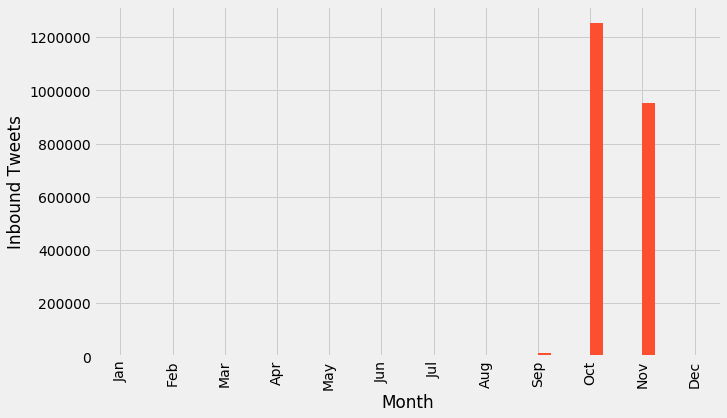

In [30]:
month_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthGroup.plot(kind='bar',figsize=(10,6),legend=False)
plt.xticks(range(12),month_ticks)
plt.xlabel('Month')
plt.ylabel('Inbound Tweets')

### Tweets by Day

In [31]:
df['day'] = df.date.dt.dayofweek

In [32]:
dayGroup = df.groupby('day').inbound.count().reset_index()

Text(0,0.5,'Inbound Tweets')

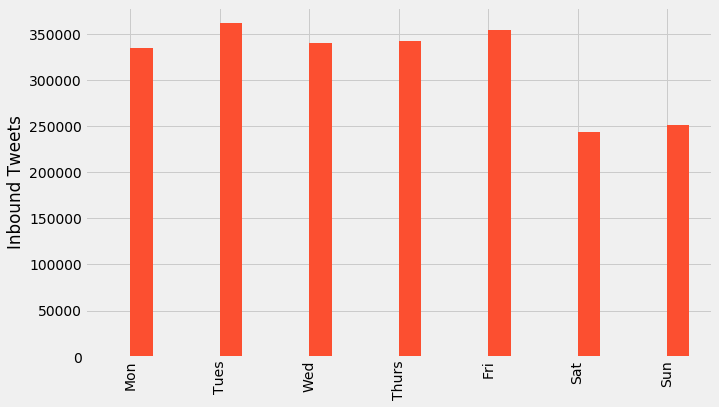

In [33]:
day_ticks = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
dayGroup.plot(kind='bar',figsize=(10,6),legend=False)
plt.xticks(range(7),day_ticks)
#plt.xlabel('Day')
plt.ylabel('Inbound Tweets')

### Tweets by Company

In [17]:
companyGroup = df.groupby('author_id').inbound.count().reset_index()

In [18]:
companyGroup = companyGroup.loc[companyGroup.iloc[:,0].str.contains(r'(^\D{6})')]
companyGroup.sort_values('inbound',ascending=False,inplace=True)

/home/xavier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [19]:
companyGroup.shape

(102, 2)

In [20]:
companyGroup

,author_id,inbound
569050,AmazonHelp,129431
569052,AppleSupport,90432
569127,Uber_Support,42289
569119,SpotifyCares,34328
569051,AmericanAir,29642
569120,TMobileHelp,28644
569141,comcastcares,26270
569075,British_Airways,24395
569118,SouthwestAir,23302
569068,Ask_Spectrum,20961


In [21]:
df.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month
0,1,VirginAtlantic,False,@95932 Hmmm they may be full. Have you tried b...,2,3.0,2017-10-04 22:37:58,10
1,2,95932,True,@VirginAtlantic Sure have. Nothing comes up at...,4,1.0,2017-10-04 22:55:58,10
2,4,VirginAtlantic,False,@95932 I'm going to report this then. It sound...,NaN,2.0,2017-10-04 23:00:12,10
3,3,95932,True,"@VirginAtlantic Yes, nothing comes up 🙁",1,5.0,2017-10-04 22:36:35,10
4,5,VirginAtlantic,False,@95932 Have you tried towards the end of March...,3,6.0,2017-10-04 20:15:59,10


In [22]:
appleDF = df[df['author_id'].str.contains("AppleSupport") | df['text'].str.contains("AppleSupport") ]

In [23]:
appleDF.shape

(171517, 8)

In [24]:
appleDF.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month
119,129,AppleSupport,False,@95972 Let's take a look at your flashlight to...,130,131.0,2017-10-04 13:04:26,10
120,130,95973,True,@AppleSupport @95972 i have the same problem w...,NaN,129.0,2017-10-04 22:10:17,10
309,385,AppleSupport,False,@96035 We want you to get the most out of your...,NaN,386.0,2017-10-04 12:33:00,10
339,416,AppleSupport,False,"@96041 We appreciate you letting us know, does...",NaN,417.0,2017-10-04 12:59:29,10
340,417,96041,True,@AppleSupport When you go to the App Store &am...,416,418.0,2017-10-04 04:57:54,10


### Tweets by Conversations

In [15]:
testDF = df[(df['author_id'].str.contains("95972"))]

In [16]:
testDF.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,date
121,131,95972,True,Wed Oct 04 05:43:36 +0000 2017,the update made my fuckin flashlight stop work...,129,NaN,2017-10-04 05:43:36
366775,398930,195972,True,Fri Oct 13 13:12:57 +0000 2017,"@AmazonHelp Si, pero ya no soluciona nada, lo ...",398932,398929.0,2017-10-13 13:12:57
366777,398933,195972,True,Fri Oct 13 13:16:54 +0000 2017,@AmazonHelp No voy a perder más tiempo en esto...,NaN,398932.0,2017-10-13 13:16:54
366778,398931,195972,True,Fri Oct 13 12:56:40 +0000 2017,Gracias por nada @96220 @99212 https://t.co/K2...,398929,NaN,2017-10-13 12:56:40
758859,701554,295972,True,Sat Oct 21 17:24:07 +0000 2017,"@97286 No. Demasiado caro. Lo siento, @97286, ...","822262,822263,822264",701546.0,2017-10-21 17:24:07


In [17]:
testDF.to_csv('../data/test.csv')

## Text Processing

In [18]:
%time doc_clean = [clean(doc).split() for doc in appleDF.text]  

CPU times: user 11.3 s, sys: 172 ms, total: 11.4 s
Wall time: 11.5 s


In [39]:
doc_clean[-1][:]

['669057',
 'know',
 'critical',
 'able',
 'charge',
 'iphone',
 'please',
 'try',
 'step',
 'section',
 'if',
 'alert',
 'say',
 'accessory',
 'isnt',
 'supported',
 'certified',
 'here',
 'httpstcouqxquyfdn0',
 'doesnt',
 'help',
 'please',
 'dm',
 'u',
 'exact',
 'version',
 'io',
 'running',
 'httpstcogdrqu22ypt']

## Quick LDA

In [52]:
import gensim
from gensim import corpora

In [53]:
dictionary = corpora.Dictionary(doc_clean)

In [54]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [55]:
lda = gensim.models.ldamodel.LdaModel

In [155]:
%time ldamodel = lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=10)

CPU times: user 27min 8s, sys: 4.78 s, total: 27min 13s
Wall time: 27min 2s


In [156]:
print(ldamodel.print_topics(num_topics=5, num_words=3))

[(0, '0.052*"issue" + 0.046*"update" + 0.024*"software"'), (1, '0.070*"u" + 0.051*"dm" + 0.049*"httpstcogdrqu22ypt"'), (2, '0.027*"applesupport" + 0.017*"apple" + 0.017*"app"'), (3, '0.034*"here" + 0.033*"support" + 0.026*"help"'), (4, '0.098*"applesupport" + 0.025*"phone" + 0.024*"io"')]


In [157]:
for topic in ldamodel.show_topics(num_topics=6, formatted=False, num_words=6):
    print("Topic {}: Words: ".format(topic[0]))
    topicwords = [w for (w, val) in topic[1]]
    print(topicwords)

Topic 0: Words: 
['issue', 'update', 'software', 'work', 'it’s', 'question']
Topic 1: Words: 
['u', 'dm', 'httpstcogdrqu22ypt', 'let', 'help', 'know']
Topic 2: Words: 
['applesupport', 'apple', 'app', 'back', 'apps', 'device']
Topic 3: Words: 
['here', 'support', 'help', 'contact', 'right', 'get']
Topic 4: Words: 
['applesupport', 'phone', 'io', 'iphone', 'update', 'fix']


In [158]:
joblib.dump(ldamodel, '../models/lda.pkl')

['../models/lda.pkl']

## Quick NMF

In [67]:
tf = TfidfVectorizer(stop_words=stop,use_idf=True,token_pattern="\\b[a-z][a-z]+\\b",max_df=.8,min_df=.05)
x = tf.fit_transform(appleDF.text)
tf_feature_names = tf.get_feature_names()

In [68]:
nmf = NMF(n_components=5, init='random')
nmf_fit = nmf.fit_transform(x)

In [69]:
joblib.dump(nmf, '../models/nmf.pkl')

['../models/nmf.pkl']

In [70]:
display_topics(nmf,tf_feature_names,6)

Topic 0:
iphone apple using phone happy update
Topic 1:
help happy device using issue apple
Topic 2:
update issue work software phone apple
Topic 3:
please happy apple device issue using
Topic 4:
ios version using device phone happy


### Topic Model Print Test

### Clean Apple Tweets

In [25]:
appleDF['clean'] = appleDF.text.apply(lambda x: process_tweet_text(x))

/home/xavier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
appleDF.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date,month,clean
119,129,AppleSupport,False,@95972 Let's take a look at your flashlight to...,130,131.0,2017-10-04 13:04:26,10,"take,look,flashlight,together,recently,version..."
120,130,95973,True,@AppleSupport @95972 i have the same problem w...,NaN,129.0,2017-10-04 22:10:17,10,"problem,led,doesnt,work,since"
309,385,AppleSupport,False,@96035 We want you to get the most out of your...,NaN,386.0,2017-10-04 12:33:00,10,"want,get,happening,specifically"
339,416,AppleSupport,False,"@96041 We appreciate you letting us know, does...",NaN,417.0,2017-10-04 12:59:29,10,"appreciate,know,happen,cellular,data"
340,417,96041,True,@AppleSupport When you go to the App Store &am...,416,418.0,2017-10-04 04:57:54,10,"pick,randomly,like,image,video,sec,play,whole"


In [83]:
tf2 = TfidfVectorizer(stop_words=stop,use_idf=True,max_df=.2,min_df=.05)
x2 = tf2.fit_transform(appleDF.clean)
tf2_feature_names = tf2.get_feature_names()

In [84]:
no_topics = 5
nmf_model = NMF(n_components=no_topics,init='random').fit(x2)
nmf_W = nmf_model.transform(x2)
nmf_H = nmf_model.components_

In [85]:
display_topics(nmf_model,tf2_feature_names,5)

Topic 0:
issue work device version update
Topic 1:
phone work version update issue
Topic 2:
happy device issue work version
Topic 3:
update work device version phone
Topic 4:
version device work update phone


In [86]:
documents = list(appleDF.text)

In [87]:
no_top_words = 5
no_top_documents = 2
display_topics2(nmf_H, nmf_W, tf2_feature_names, documents, no_top_words, no_top_documents)

Topic 0:
issue work device version update
@AppleSupport 11.1.1 fixed the weird I to a? autocorrect issue but it didn’t fix the “it” correcting to I.t issue. Text replacement doesn’t work, either. It’s really frustrating. https://t.co/0JLjzIIauf
Is it an @ATT issue or an @AppleSupport issue that I must toggle airplane mode several times a day to get LTE to work? Need @101119 ?
Topic 1:
phone work version update issue
@AppleSupport i purchased an iphone 8+ yesterday and my contacts appeared on my new phone after I entered my apple i.d. this a new feature?
@AppleSupport My phone will just power off no matter the percentage of the battery. And when I plug my phone into my charger it charges and turn on
Topic 2:
happy device issue work version
@163032 We'll be happy to look into this with you. Go ahead and DM us what you're seeing with your clock here: https://t.co/GDrqU22YpT
@118013 Sure! We're happy to look into this with you. Send us a DM and we'll take a look at your battery. https://t.

## Quick Cluster

In [88]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0)
results = tsne_model.fit_transform(nmf_W) 



In [91]:
joblib.dump(tsne_model, '../models/tsne.pkl')

['../models/tsne.pkl']

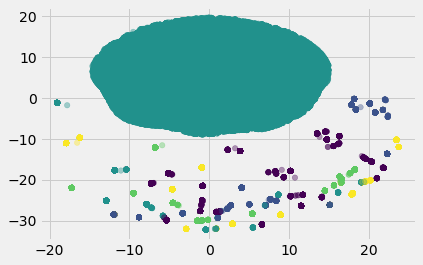

In [97]:
def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

x, y = get_coords(results)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(nmf_W)

# Scatter plot with colouring by kmeans labels:
plt.scatter(x, y, alpha=0.4, c=kmeans.labels_, marker='o', s=30);

In [95]:
joblib.dump(kmeans, '../models/kmeans.pkl')

['../models/kmeans.pkl']

In [99]:
print(kmeans.labels_)

[4 0 2 ..., 2 2 2]


In [101]:
labels = kmeans.predict(nmf_W)

In [102]:
clusters = {}
n = 0
for item in labels:
    if item in clusters:
        clusters[item].append(row_dict[n])
    else:
        clusters[item] = [row_dict[n]]
    n +=1

IndentationError: unexpected indent (<ipython-input-102-3324e3765531>, line 2)